# Model Monitoring for Cardiac Image Segmentation

## Import

### Data

In [1]:
!git clone https://github.com/manigalati/quality_control_CMR

Cloning into 'quality_control_CMR'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [2]:
%cd quality_control_CMR/

/content/quality_control_CMR


In [3]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/

data/training.zip
[==================================================] 1554.02MB/1554.02MB
data/predictions.zip
[==================================================] 3.75MB/3.75MB


In [4]:
!unzip -q data/training.zip -d data/

In [5]:
!unzip -q data/predictions.zip -d data/
!mv data/predictions data/testing

### Lib

In [6]:
import random
import numpy as np
import torch

In [7]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
from utils import *
from CA import *

## Data preparation

In [9]:
gt=get_gt("data/training/")

In [10]:
images_gt=np.array([img for _,img in gt["ED"]]+[img for _,img in gt["ES"]])
blank=torch.zeros(images_gt.shape[:1]+(len(np.unique(images_gt)),)+images_gt.shape[1:],dtype=int)
images_gt=blank.scatter_(1,torch.tensor(np.expand_dims(images_gt,axis=1)),1)

In [11]:
BATCH_SIZE = 8

images_train = images_gt[:int(np.floor(.8*images_gt.shape[0]))]
images_val = images_gt[int(np.floor(.8*images_gt.shape[0])):]

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(images_train.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(images_val.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

## Training

In [12]:
ae = AE(latent_size=100).to(device)
print(ae)

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

In [13]:
ae.train()
history = ae.training_routine(500,train_loader,val_loader)

Epoch [0], GDLoss: 0.0976 MSELoss: 0.0150 Total: 0.1126 
Epoch [1], GDLoss: 0.0458 MSELoss: 0.0136 Total: 0.0595 
Epoch [2], GDLoss: 0.0394 MSELoss: 0.0135 Total: 0.0530 
Epoch [3], GDLoss: 0.0337 MSELoss: 0.0098 Total: 0.0435 
Epoch [4], GDLoss: 0.0226 MSELoss: 0.0081 Total: 0.0307 
Epoch [5], GDLoss: 0.0219 MSELoss: 0.0091 Total: 0.0310 
Epoch [6], GDLoss: 0.0188 MSELoss: 0.0080 Total: 0.0268 
Epoch [7], GDLoss: 0.0185 MSELoss: 0.0081 Total: 0.0266 
Epoch [8], GDLoss: 0.0181 MSELoss: 0.0081 Total: 0.0262 
Epoch [9], GDLoss: 0.0182 MSELoss: 0.0082 Total: 0.0264 
Epoch [10], GDLoss: 0.0178 MSELoss: 0.0080 Total: 0.0258 
Epoch [11], GDLoss: 0.0175 MSELoss: 0.0079 Total: 0.0254 
Epoch [12], GDLoss: 0.0174 MSELoss: 0.0079 Total: 0.0253 
Epoch [13], GDLoss: 0.0173 MSELoss: 0.0079 Total: 0.0253 
Epoch [14], GDLoss: 0.0173 MSELoss: 0.0079 Total: 0.0252 
Epoch [15], GDLoss: 0.0173 MSELoss: 0.0079 Total: 0.0252 
Epoch [16], GDLoss: 0.0174 MSELoss: 0.0080 Total: 0.0254 
Epoch [17], GDLoss: 0.01

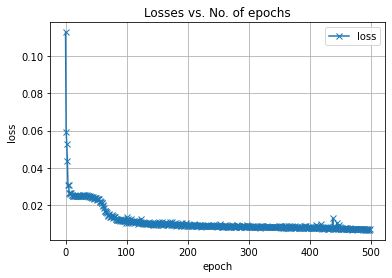

In [14]:
plot_history(history)

## Testing

In [15]:
# LOAD MODEL
ae=torch.load("best_ae.pth",map_location=device)
ae.eval();

### Data preparation

In [16]:
model="Bai"
test=get_test("data/testing/"+model+"/")

In [17]:
images_test=np.array([img for _,img in test["ED"]]+[img for _,img in test["ES"]])
blank=torch.zeros(images_test.shape[:1]+(len(np.unique(images_test)),)+images_test.shape[1:],dtype=int)
images_test=blank.scatter_(1,torch.tensor(np.expand_dims(images_test,axis=1)),1)

In [18]:
BATCH_SIZE=8

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(images_test.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

### Single patient

In [19]:
patient="patient102"

if patient=="empty":
  reference=np.zeros([1,4,256,256])
  reference[:,0]=1
else:
  reference=images_test[np.array([p for p,_ in test["ED"]]+[p for p,_ in test["ES"]])==patient].numpy()

In [20]:
%time
prediction=ae(torch.tensor(reference).float().to(device)).cpu().detach().numpy()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [21]:
reference=np.argmax(reference,axis=1)
prediction={
    "discrete":np.argmax(prediction,axis=1),
    "continuous":np.argmax(prediction,axis=1)+(1-np.max(prediction,axis=1))
}

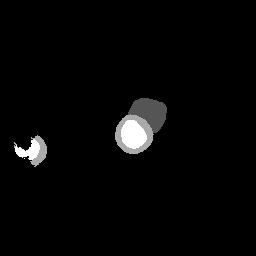

In [22]:
display_image(reference[2])

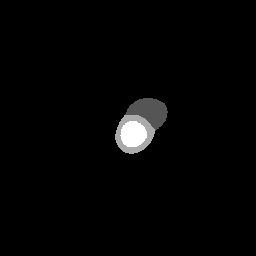

In [23]:
display_image(prediction["discrete"][2])

In [24]:
%time
get_results(prediction["discrete"],reference)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


{'Dice': 1.1914343311399338,
 'Dice_rint': 0.8837968728379687,
 'HD_rint': 101.67595585978034,
 'LV_Dice': 1.245235337474992,
 'LV_Dice_rint': 0.7920433996383364,
 'LV_HD_rint': 105.15702544290609,
 'LV_SED': 18630,
 'LV_SED_rint': 18630.0,
 'LV_maxSED': 3717,
 'LV_maxSED_rint': 3717.0,
 'MYO_Dice': 0.99899954524784,
 'MYO_Dice_rint': 0.7532057875608585,
 'MYO_HD_rint': 101.67595585978034,
 'MYO_SED': 14396,
 'MYO_SED_rint': 14396.0,
 'MYO_maxSED': 1944,
 'MYO_maxSED_rint': 1944.0,
 'RV_Dice': 0.8696326952922918,
 'RV_Dice_rint': 0.8696326952922918,
 'RV_HD_rint': 8.48528137423857,
 'RV_SED': 1512,
 'RV_SED_rint': 1512.0,
 'RV_maxSED': 261,
 'RV_maxSED_rint': 261.0,
 'SED': 20038,
 'SED_rint': 20038.0,
 'maxSED': 4277,
 'maxSED_rint': 4277.0}

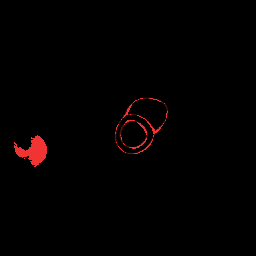

In [25]:
display_difference(prediction["continuous"][2],reference[2])

### All patients

In [26]:
reference=np.array([img for _,img in test["ED"]]+[img for _,img in test["ES"]])

In [27]:
prediction=np.array([])
for [batch] in test_loader:
  batch=batch.to(device)
  reconstruction=ae(batch).cpu().detach().numpy()
  if(len(prediction)==0):
    prediction=reconstruction
  else:
    prediction=np.concatenate([prediction,reconstruction])

In [28]:
prediction=np.argmax(prediction,axis=1)

In [29]:
results={"ED":{},"ES":{}}
for patient in np.unique([p for p,_ in test["ED"]]+[p for p,_ in test["ES"]]):
  results["ED"][patient]=get_results(prediction[:len(test["ED"])][np.array([p for p,_ in test["ED"]])==patient],reference[:len(test["ED"])][np.array([p for p,_ in test["ED"]])==patient])
  results["ES"][patient]=get_results(prediction[len(test["ED"]):][np.array([p for p,_ in test["ES"]])==patient],reference[len(test["ED"]):][np.array([p for p,_ in test["ES"]])==patient])

In [30]:
np.save(model+'_AE_ED+ES',results)